In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import Adam
import soundfile as sf

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import cv2
import numpy as np
from pathlib import Path

import tqdm
import sys
sys.path.append("..")
# from dataset import IsoNetDataset
import os 

# --- CONFIGURATION FROM DIAGRAM ---
VISUAL_DIM = 256       # Output of Visual Stream (V)
SPATIAL_DIM = 128      # Output of Spatial Stream (S)
AUDIO_ENC_DIM = 512    # Internal Audio Feature Dimension
AUDIO_CHANNELS = 4     # Number of Mics

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Memory-Optimized Training Configuration for 8GB GPU
BATCH_SIZE = 4          # Small batch size for 8GB GPU
GRADIENT_ACCUMULATION_STEPS = 8  # Effective batch size = 1 * 8 = 8
EPOCHS = 100
LR = 1e-4               # TCNs prefer lower learning rates
CHECKPOINT_DIR = "checkpoints"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Mixed Precision Training
USE_AMP = True  # Automatic Mixed Precision (FP16) saves ~40% memory

print(f"Device: {DEVICE}")
print(f"Mixed Precision: {USE_AMP}")
print(f"Batch Size: {BATCH_SIZE} | Gradient Accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective Batch Size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

Device: cuda
Mixed Precision: True
Batch Size: 4 | Gradient Accumulation: 8
Effective Batch Size: 32


In [2]:
torch.cuda.empty_cache()        # free cached memory
torch.cuda.synchronize()        # wait for all kernels to finish

In [3]:
# ============================================================
# MEMORY OPTIMIZATION FOR 8GB GPU
# ============================================================

# Clear cache and optimize PyTorch settings
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Enable cuDNN benchmarking for faster training (if input sizes are fixed)
torch.backends.cudnn.benchmark = True

# Enable TF32 on Ampere GPUs for faster training (A100, A6000, RTX 30/40 series)
if hasattr(torch.backends.cuda, 'matmul'):
    torch.backends.cuda.matmul.allow_tf32 = True
if hasattr(torch.backends.cudnn, 'allow_tf32'):
    torch.backends.cudnn.allow_tf32 = True

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Print GPU info
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available Memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1e9:.2f} GB")
    print(f"Compute Capability: {torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}")

GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Total Memory: 6.09 GB
Available Memory: 6.09 GB
Compute Capability: 8.6


In [4]:
# ============================================================
# DATASET PATHS CONFIGURATION (Centralized)
# ============================================================
# All data paths are defined here for easy modification
# Update ONLY this cell when changing data locations

import platform
from pathlib import Path

# Detect OS and set paths accordingly
IS_WINDOWS = platform.system() == "Windows"

# ===== EDIT THESE PATHS FOR YOUR SYSTEM =====
# Windows paths
WINDOWS_PATHS = {
    "root_dir": "C:\\Users\\bibek\\isolate-speech",
    "multich_dir": "C:\\Users\\bibek\\isolate-speech\\data\\multich",
    "mp4_dir": "C:\\Users\\bibek\\isolate-speech\\data\\mp4",
}

# Linux paths - Using new simulation output with full spatial metadata
LINUX_PATHS = {
    "root_dir": "/mnt/DATA/Bibek/Speech/isolate-speech",
    # NEW: Use the external drive with full spatial metadata (15 columns!)
    "multich_dir": "/run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich",
    "mp4_dir": "/mnt/DATA/Bibek/Speech/isolate-speech/data/mp4",
}

# Select paths based on OS
PATHS = WINDOWS_PATHS if IS_WINDOWS else LINUX_PATHS

# ===== GLOBAL PATH VARIABLES =====
ROOT_DIR = Path(PATHS["root_dir"])
MULTICH_DIR = Path(PATHS["multich_dir"])
MP4_DIR = Path(PATHS["mp4_dir"])

# Derived paths from MULTICH_DIR
METADATA_CSV = str(MULTICH_DIR / "metadata.csv")
TRAIN_CSV = str(MULTICH_DIR / "train.csv") if (MULTICH_DIR / "train.csv").exists() else METADATA_CSV
VAL_CSV = str(MULTICH_DIR / "val.csv") if (MULTICH_DIR / "val.csv").exists() else METADATA_CSV
TEST_CSV = str(MULTICH_DIR / "test.csv") if (MULTICH_DIR / "test.csv").exists() else METADATA_CSV

# Audio/Video subdirectories within MULTICH_DIR
MIXED_DIR = MULTICH_DIR / "mixed"
CLEAN_DIR = MULTICH_DIR / "clean"
VIDEO_DIR = MULTICH_DIR / "video"

# Print configuration
print(f"{'='*60}")
print(f"DATA PATHS CONFIGURATION")
print(f"{'='*60}")
print(f"OS:           {platform.system()}")
print(f"ROOT_DIR:     {ROOT_DIR}")
print(f"MULTICH_DIR:  {MULTICH_DIR}")
print(f"MP4_DIR:      {MP4_DIR}")
print(f"MIXED_DIR:    {MIXED_DIR}")
print(f"CLEAN_DIR:    {CLEAN_DIR}")
print(f"VIDEO_DIR:    {VIDEO_DIR}")
print(f"METADATA_CSV: {METADATA_CSV}")
print(f"TRAIN_CSV:    {TRAIN_CSV}")
print(f"VAL_CSV:      {VAL_CSV}")
print(f"{'='*60}")

# Verify paths exist
print(f"\n--- PATH VERIFICATION ---")
for name, path in [("MULTICH_DIR", MULTICH_DIR), ("MP4_DIR", MP4_DIR), 
                   ("MIXED_DIR", MIXED_DIR), ("CLEAN_DIR", CLEAN_DIR), 
                   ("VIDEO_DIR", VIDEO_DIR)]:
    exists = path.exists()
    status = "OK" if exists else "MISSING"
    print(f"  {name}: {status}")

# Check metadata
if Path(METADATA_CSV).exists():
    import pandas as pd
    meta_df = pd.read_csv(METADATA_CSV)
    print(f"\n--- METADATA INFO ---")
    print(f"  Samples: {len(meta_df)}")
    print(f"  Columns: {list(meta_df.columns)}")
else:
    print(f"\n  METADATA_CSV not found!")

DATA PATHS CONFIGURATION
OS:           Linux
ROOT_DIR:     /mnt/DATA/Bibek/Speech/isolate-speech
MULTICH_DIR:  /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich
MP4_DIR:      /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4
MIXED_DIR:    /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/mixed
CLEAN_DIR:    /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/clean
VIDEO_DIR:    /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/video
METADATA_CSV: /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/metadata.csv
TRAIN_CSV:    /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/train.csv
VAL_CSV:      /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/val.csv

--- PATH VERIFICATION ---
  MULTICH_DIR: OK
  MP4_DIR: OK
  MIXED_DIR: OK
  CLEAN_DIR: OK
  VIDEO_DIR: OK

--- METADATA INFO ---
  Samples: 15000
  Columns: ['filename', 'source_wav', 'source_video', 'start_time', 'mixed_audio', 'clean_audio', 'video_file', 'target_azimuth'

## Spatial-Visual Augmentation Demo

This demonstrates how we map face positions to match the spatial angles from the metadata.
The core insight: VoxCeleb videos have **centered faces** (frontal interviews), but our audio simulation places speakers at **varying angles**. 

**Solution**: Shift the face position in the frame to match the spatial angle!
- Azimuth (horizontal angle) → Shift face left/right
- Elevation (vertical angle) → Shift face up/down
- Distance → Scale face size

In [5]:
# ============================================================
# SPATIAL-VISUAL AUGMENTATION MODULE
# ============================================================
# This transforms video frames based on spatial metadata to create
# visual-spatial correspondence that the model can learn
#
# KEY INSIGHT: Dataset has azimuth 0-2π (full 360°), but camera FOV is limited.
# We need to map the RELATIVE angle within the camera's view.

import cv2
import numpy as np
import torch

# ===== VIDEO SIZE CONFIGURATION =====
# Larger canvas allows more room for spatial shifting without cutting off faces
VIDEO_SIZE_SMALL = (224, 224)   # Original ResNet input
VIDEO_SIZE_MEDIUM = (336, 336)  # 1.5x larger - good balance
VIDEO_SIZE_LARGE = (448, 448)   # 2x larger - max detail but more memory

# Choose active size (increase for better spatial augmentation)
VIDEO_SIZE = VIDEO_SIZE_MEDIUM  # Using medium for better spatial range

print(f"Video Size Configuration: {VIDEO_SIZE}")

class SpatialVisualAugmenter:
    """
    Augments video frames based on spatial metadata (azimuth, elevation, distance).
    Maps speaker's spatial position to their visual position in the frame.
    
    Handles full 360° azimuth by wrapping to camera's visible FOV.
    """
    
    def __init__(self, camera_fov_horizontal=90.0, camera_fov_vertical=60.0, 
                 camera_direction=0.0, augmentation_strength=1.0):
        """
        Args:
            camera_fov_horizontal: Horizontal field of view in degrees (default: 90)
            camera_fov_vertical: Vertical field of view in degrees (default: 60)
            camera_direction: Direction camera is pointing in radians (default: 0)
            augmentation_strength: How much to apply augmentation (0.0 = none, 1.0 = full)
        """
        self.fov_h = np.radians(camera_fov_horizontal)  # Convert to radians
        self.fov_v = np.radians(camera_fov_vertical)
        self.camera_dir = camera_direction
        self.strength = augmentation_strength
        
    def normalize_angle(self, angle):
        """Normalize angle to [-π, π] range"""
        while angle > np.pi:
            angle -= 2 * np.pi
        while angle < -np.pi:
            angle += 2 * np.pi
        return angle
    
    def azimuth_to_camera_relative(self, azimuth):
        """
        Convert world azimuth (0 to 2π) to camera-relative angle.
        
        Camera points at camera_direction (default 0).
        Returns angle relative to camera center: -π to +π
        """
        # Compute relative angle
        relative = self.normalize_angle(azimuth - self.camera_dir)
        return relative
    
    def spatial_to_frame_position(self, azimuth, elevation):
        """
        Convert spatial angles to normalized frame position.
        
        Args:
            azimuth: World azimuth in radians (0 to 2π)
            elevation: Elevation in radians
            
        Returns:
            (x, y): Normalized position where (0.5, 0.5) is center
                    x: 0=left edge, 1=right edge
                    y: 0=top edge, 1=bottom edge
        """
        # Convert to camera-relative angle
        cam_relative_az = self.azimuth_to_camera_relative(azimuth)
        
        # Map camera-relative azimuth to horizontal position
        # cam_relative_az in [-π, π], visible range is [-FOV/2, +FOV/2]
        # Angles outside FOV get clamped to edge
        half_fov = self.fov_h / 2
        x_normalized = cam_relative_az / half_fov  # -1 to +1 for visible range
        x_normalized = np.clip(x_normalized, -1, 1)
        x = 0.5 + (x_normalized * 0.4 * self.strength)  # 0.1 to 0.9 range (with margin)
        
        # Map elevation to vertical position (inverted: higher elevation = higher in frame)
        half_fov_v = self.fov_v / 2
        y_normalized = elevation / half_fov_v
        y_normalized = np.clip(y_normalized, -1, 1)
        y = 0.5 - (y_normalized * 0.3 * self.strength)  # 0.2 to 0.8 range
        
        return x, y
    
    def get_distance_scale(self, distance, ref_distance=1.0):
        """
        Calculate scale factor based on distance.
        Closer = larger, farther = smaller.
        
        Args:
            distance: Speaker distance in meters
            ref_distance: Reference distance (1.0m = no scaling)
        """
        # Inverse relationship: closer = bigger
        scale = ref_distance / max(distance, 0.5)  # Clamp to prevent extreme scaling
        scale = np.clip(scale, 0.7, 1.5)  # Reasonable range
        return scale
    
    def augment_frame(self, frame, azimuth, elevation, distance=1.0):
        """
        Augment a single frame based on spatial position.
        
        Args:
            frame: numpy array [H, W, C] or [H, W]
            azimuth: horizontal angle in radians (0 to 2π world coordinates)
            elevation: vertical angle in radians
            distance: distance in meters (affects scale)
        
        Returns:
            Augmented frame with face shifted to match spatial position
        """
        if isinstance(frame, torch.Tensor):
            frame = frame.numpy()
        
        H, W = frame.shape[:2]
        
        # Get target position
        target_x, target_y = self.spatial_to_frame_position(azimuth, elevation)
        
        # Calculate shift from center (0.5, 0.5)
        shift_x = (target_x - 0.5) * W
        shift_y = (target_y - 0.5) * H
        
        # Get distance-based scale
        scale = self.get_distance_scale(distance)
        
        # Create affine transformation matrix
        # For scaling + translation, we use a 2x3 matrix
        center_x, center_y = W / 2, H / 2
        
        # Build transformation: translate to origin, scale, translate back, then shift
        M = np.float32([
            [scale, 0, (1 - scale) * center_x + shift_x],
            [0, scale, (1 - scale) * center_y + shift_y]
        ])
        
        # Apply transformation
        augmented = cv2.warpAffine(
            frame, M, (W, H),
            borderMode=cv2.BORDER_REPLICATE  # Replicate edge pixels
        )
        
        return augmented
    
    def augment_video(self, video_tensor, azimuth, elevation, distance=1.0):
        """
        Augment entire video tensor.
        
        Args:
            video_tensor: [C, T, H, W] tensor
            azimuth, elevation, distance: spatial parameters
        
        Returns:
            Augmented video tensor [C, T, H, W]
        """
        C, T, H, W = video_tensor.shape
        
        # Convert to numpy for processing [T, H, W, C]
        video_np = video_tensor.permute(1, 2, 3, 0).numpy()
        
        augmented_frames = []
        for t in range(T):
            frame = video_np[t]
            aug_frame = self.augment_frame(frame, azimuth, elevation, distance)
            augmented_frames.append(aug_frame)
        
        # Convert back to tensor [C, T, H, W]
        augmented_np = np.stack(augmented_frames)  # [T, H, W, C]
        augmented_tensor = torch.from_numpy(augmented_np).permute(3, 0, 1, 2)  # [C, T, H, W]
        
        return augmented_tensor.float()

# Initialize global augmenter
augmenter = SpatialVisualAugmenter(
    camera_fov_horizontal=90.0,
    camera_fov_vertical=60.0,
    camera_direction=0.0,  # Camera points at 0° (front)
    augmentation_strength=1.0
)

print(f"\nSpatial-Visual Augmenter initialized!")
print(f"  Camera FOV: {np.degrees(augmenter.fov_h):.0f}° (H) x {np.degrees(augmenter.fov_v):.0f}° (V)")
print(f"  Camera Direction: {np.degrees(augmenter.camera_dir):.0f}°")
print(f"  Augmentation Strength: {augmenter.strength}")
print(f"\nNote: Azimuth outside camera FOV will be clamped to frame edges")

Video Size Configuration: (336, 336)

Spatial-Visual Augmenter initialized!
  Camera FOV: 90° (H) x 60° (V)
  Camera Direction: 0°
  Augmentation Strength: 1.0

Note: Azimuth outside camera FOV will be clamped to frame edges


In [6]:
# ============================================================
# DEMO: Visualize Spatial Augmentation with Metadata
# ============================================================
# Shows original vs augmented video with the spatial angles displayed

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Use centralized paths from configuration cell
print(f"Loading spatial metadata from: {METADATA_CSV}")
spatial_meta = pd.read_csv(METADATA_CSV)

# Check available columns
print(f"\nAvailable columns ({len(spatial_meta.columns)} total):")
for i, col in enumerate(spatial_meta.columns):
    print(f"  {i+1:2d}. {col}")

print(f"\nTotal samples: {len(spatial_meta)}")

# Show sample metadata entries with ALL spatial info
print(f"\n{'='*80}")
print("SAMPLE METADATA WITH FULL SPATIAL INFORMATION")
print(f"{'='*80}")

# Check if we have full spatial metadata
has_full_spatial = 'target_azimuth' in spatial_meta.columns

if has_full_spatial:
    # Show spatial angles
    print("\n--- SPEAKER POSITION (Target) ---")
    display_cols = ['filename', 'target_azimuth', 'target_elevation', 'target_distance']
    print(spatial_meta[display_cols].head(8).to_string())
    
    # Show room acoustics
    print("\n--- ROOM ACOUSTICS ---")
    room_cols = ['filename', 'room_x', 'room_y', 'room_z', 'rt60']
    print(spatial_meta[room_cols].head(8).to_string())
    
    # Show audio conditions
    print("\n--- AUDIO CONDITIONS ---")
    audio_cols = ['filename', 'snr_db']
    print(spatial_meta[audio_cols].head(8).to_string())
    
    # Statistics
    print(f"\n{'='*80}")
    print("SPATIAL STATISTICS")
    print(f"{'='*80}")
    print(f"\nTarget Position:")
    print(f"  Azimuth:   {spatial_meta['target_azimuth'].min():.2f} to {spatial_meta['target_azimuth'].max():.2f} rad")
    print(f"             ({np.degrees(spatial_meta['target_azimuth'].min()):.1f} deg to {np.degrees(spatial_meta['target_azimuth'].max()):.1f} deg)")
    print(f"  Elevation: {spatial_meta['target_elevation'].min():.2f} to {spatial_meta['target_elevation'].max():.2f} rad")
    print(f"             ({np.degrees(spatial_meta['target_elevation'].min()):.1f} deg to {np.degrees(spatial_meta['target_elevation'].max()):.1f} deg)")
    print(f"  Distance:  {spatial_meta['target_distance'].min():.2f} to {spatial_meta['target_distance'].max():.2f} m")
    
    print(f"\nRoom Dimensions:")
    print(f"  Width (X):  {spatial_meta['room_x'].min():.2f} to {spatial_meta['room_x'].max():.2f} m")
    print(f"  Depth (Y):  {spatial_meta['room_y'].min():.2f} to {spatial_meta['room_y'].max():.2f} m")
    print(f"  Height (Z): {spatial_meta['room_z'].min():.2f} to {spatial_meta['room_z'].max():.2f} m")
    print(f"  RT60:       {spatial_meta['rt60'].min():.0f} to {spatial_meta['rt60'].max():.0f} ms")
    
    print(f"\nAudio Conditions:")
    print(f"  SNR:        {spatial_meta['snr_db'].min():.1f} to {spatial_meta['snr_db'].max():.1f} dB")
    
else:
    print("(Using old metadata format with limited columns)")
    display_cols = ['filename', 'azimuth', 'snr_db']
    print(spatial_meta[display_cols].head(10).to_string())

Loading spatial metadata from: /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/metadata.csv

Available columns (15 total):
   1. filename
   2. source_wav
   3. source_video
   4. start_time
   5. mixed_audio
   6. clean_audio
   7. video_file
   8. target_azimuth
   9. target_elevation
  10. target_distance
  11. room_x
  12. room_y
  13. room_z
  14. rt60
  15. snr_db

Total samples: 15000

SAMPLE METADATA WITH FULL SPATIAL INFORMATION

--- SPEAKER POSITION (Target) ---
       filename  target_azimuth  target_elevation  target_distance
0  sample_00000          1.8516            0.3261           0.9082
1  sample_00001          3.9774            0.4927           1.0557
2  sample_00002          6.0836            0.1914           1.2813
3  sample_00003          0.9729            0.4435           1.4459
4  sample_00004          4.6955            0.3298           0.8436
5  sample_00005          1.8736           -0.0884           1.1093
6  sample_00006          4.6121           


SPATIAL AUGMENTATION VISUALIZATION
Sample: sample_00005
Video:  /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4/id08746/jxOedMfelw4/00165.mp4

--- SPATIAL METADATA ---
Azimuth:   1.8736 rad (107.3 deg)
Elevation: -0.0884 rad (-5.1 deg)
Distance:  1.11 m
SNR:       3.0 dB

Loading video...
Video loaded: torch.Size([3, 50, 224, 224])
Augmented:   torch.Size([3, 50, 224, 224])


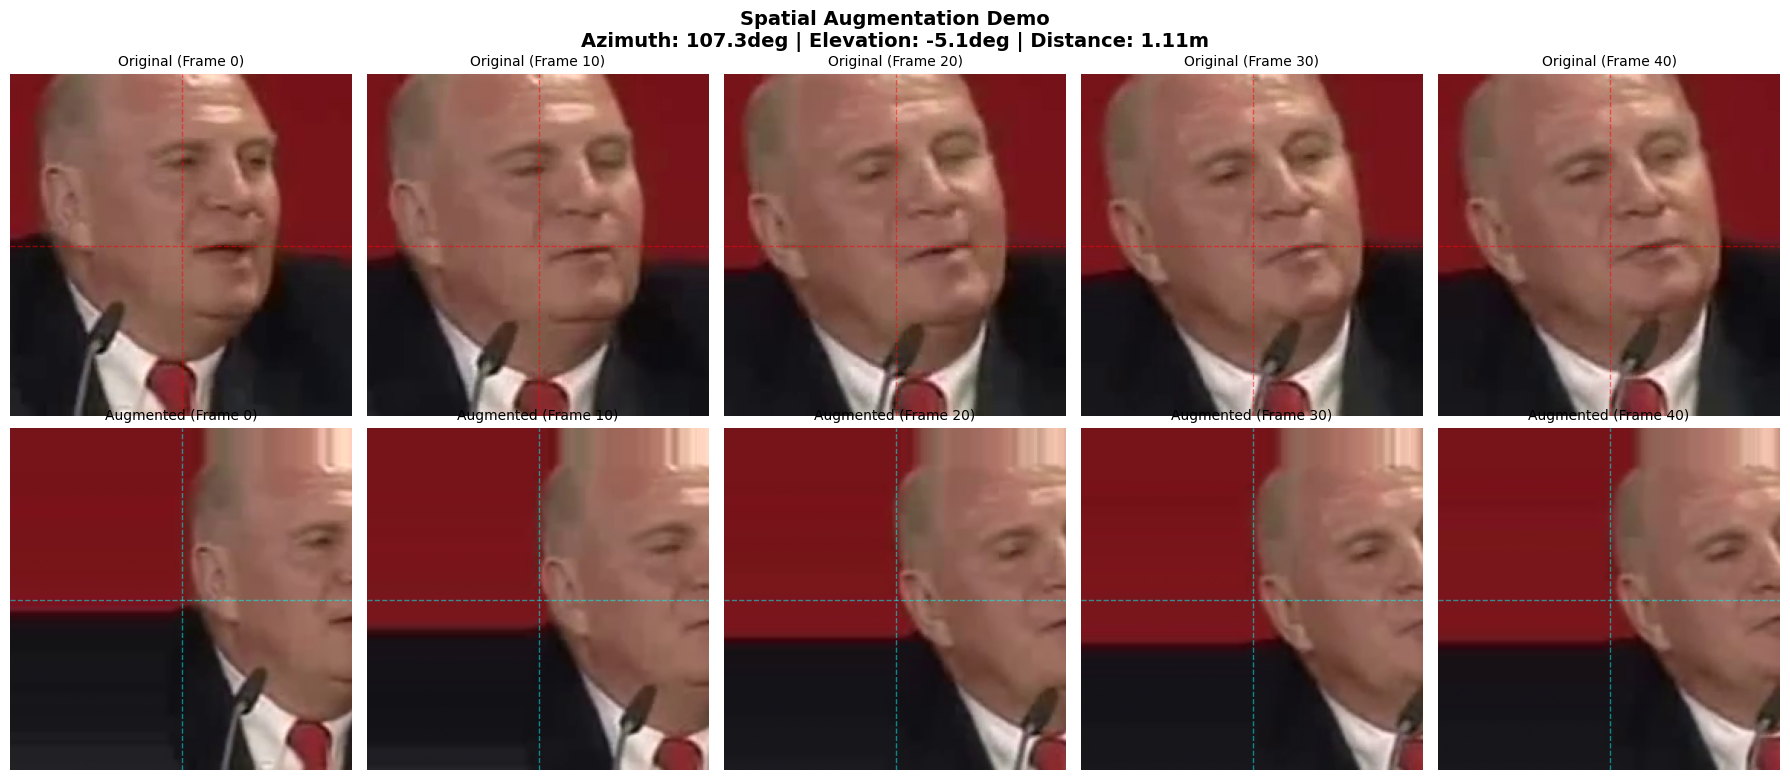


Saved: spatial_augmentation_demo.png


In [7]:
# ============================================================
# VISUALIZE: Original vs Spatially Augmented Video
# ============================================================

def load_video_for_demo(video_path, start_time=0.0, num_frames=25, size=(224, 224)):
    """Load video frames for visualization"""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Could not open: {video_path}")
        return None
    
    vid_fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    start_frame = int(start_time * vid_fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    frames = []
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, size)
        frames.append(frame)
    cap.release()
    
    if len(frames) == 0:
        return None
    
    # Pad if needed
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    # Convert to tensor [C, T, H, W]
    buffer = np.array(frames, dtype=np.float32) / 255.0
    tensor = torch.from_numpy(buffer).permute(3, 0, 1, 2)
    return tensor

# Pick a sample with interesting angles
sample_idx = 5  # Change this to explore different samples
row = spatial_meta.iloc[sample_idx]

# Get angles (handle both old and new metadata format)
if has_full_spatial:
    azimuth = float(row['target_azimuth'])
    elevation = float(row['target_elevation'])
    distance = float(row['target_distance'])
    video_rel_path = row['source_video']
else:
    azimuth = float(row['azimuth'])
    elevation = 0.15  # Default elevation
    distance = 1.0
    video_rel_path = row['video_path']

# Build video path using centralized MP4_DIR
if has_full_spatial:
    video_path = MP4_DIR / video_rel_path
else:
    if 'mp4/' in video_rel_path:
        video_path = DATA_DIR / video_rel_path.split('mp4/')[-1]
        video_path = MP4_DIR / video_rel_path.split('mp4/')[-1]
    else:
        video_path = MP4_DIR / video_rel_path

start_time = float(row['start_time'])

print(f"\n{'='*80}")
print(f"SPATIAL AUGMENTATION VISUALIZATION")
print(f"{'='*80}")
print(f"Sample: {row['filename']}")
print(f"Video:  {video_path}")
print(f"\n--- SPATIAL METADATA ---")
print(f"Azimuth:   {azimuth:.4f} rad ({np.degrees(azimuth):.1f} deg)")
print(f"Elevation: {elevation:.4f} rad ({np.degrees(elevation):.1f} deg)")
print(f"Distance:  {distance:.2f} m")
print(f"SNR:       {row['snr_db']:.1f} dB")

# Load video
print(f"\nLoading video...")
video_tensor = load_video_for_demo(video_path, start_time, num_frames=50)

if video_tensor is not None:
    print(f"Video loaded: {video_tensor.shape}")
    
    # Apply spatial augmentation
    augmented_tensor = augmenter.augment_video(video_tensor, azimuth, elevation, distance)
    print(f"Augmented:   {augmented_tensor.shape}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    fig.suptitle(f'Spatial Augmentation Demo\n'
                 f'Azimuth: {np.degrees(azimuth):.1f}deg | Elevation: {np.degrees(elevation):.1f}deg | Distance: {distance:.2f}m',
                 fontsize=14, fontweight='bold')
    
    sample_frames = [0, 10, 20, 30, 40]
    
    for i, frame_idx in enumerate(sample_frames):
        # Original frame
        orig_frame = video_tensor[:, frame_idx, :, :].permute(1, 2, 0).numpy()
        axes[0, i].imshow(orig_frame)
        axes[0, i].set_title(f'Original (Frame {frame_idx})', fontsize=10)
        axes[0, i].axis('off')
        
        # Draw center crosshair on original
        H, W = orig_frame.shape[:2]
        axes[0, i].axhline(y=H//2, color='red', linestyle='--', alpha=0.5, linewidth=1)
        axes[0, i].axvline(x=W//2, color='red', linestyle='--', alpha=0.5, linewidth=1)
        
        # Augmented frame
        aug_frame = augmented_tensor[:, frame_idx, :, :].permute(1, 2, 0).numpy()
        axes[1, i].imshow(aug_frame)
        axes[1, i].set_title(f'Augmented (Frame {frame_idx})', fontsize=10)
        axes[1, i].axis('off')
        
        # Draw center crosshair on augmented
        axes[1, i].axhline(y=H//2, color='cyan', linestyle='--', alpha=0.5, linewidth=1)
        axes[1, i].axvline(x=W//2, color='cyan', linestyle='--', alpha=0.5, linewidth=1)
    
    axes[0, 0].set_ylabel('ORIGINAL\n(Face Centered)', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('AUGMENTED\n(Face at Spatial Angle)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('spatial_augmentation_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved: spatial_augmentation_demo.png")
else:
    print(f"Could not load video from: {video_path}")

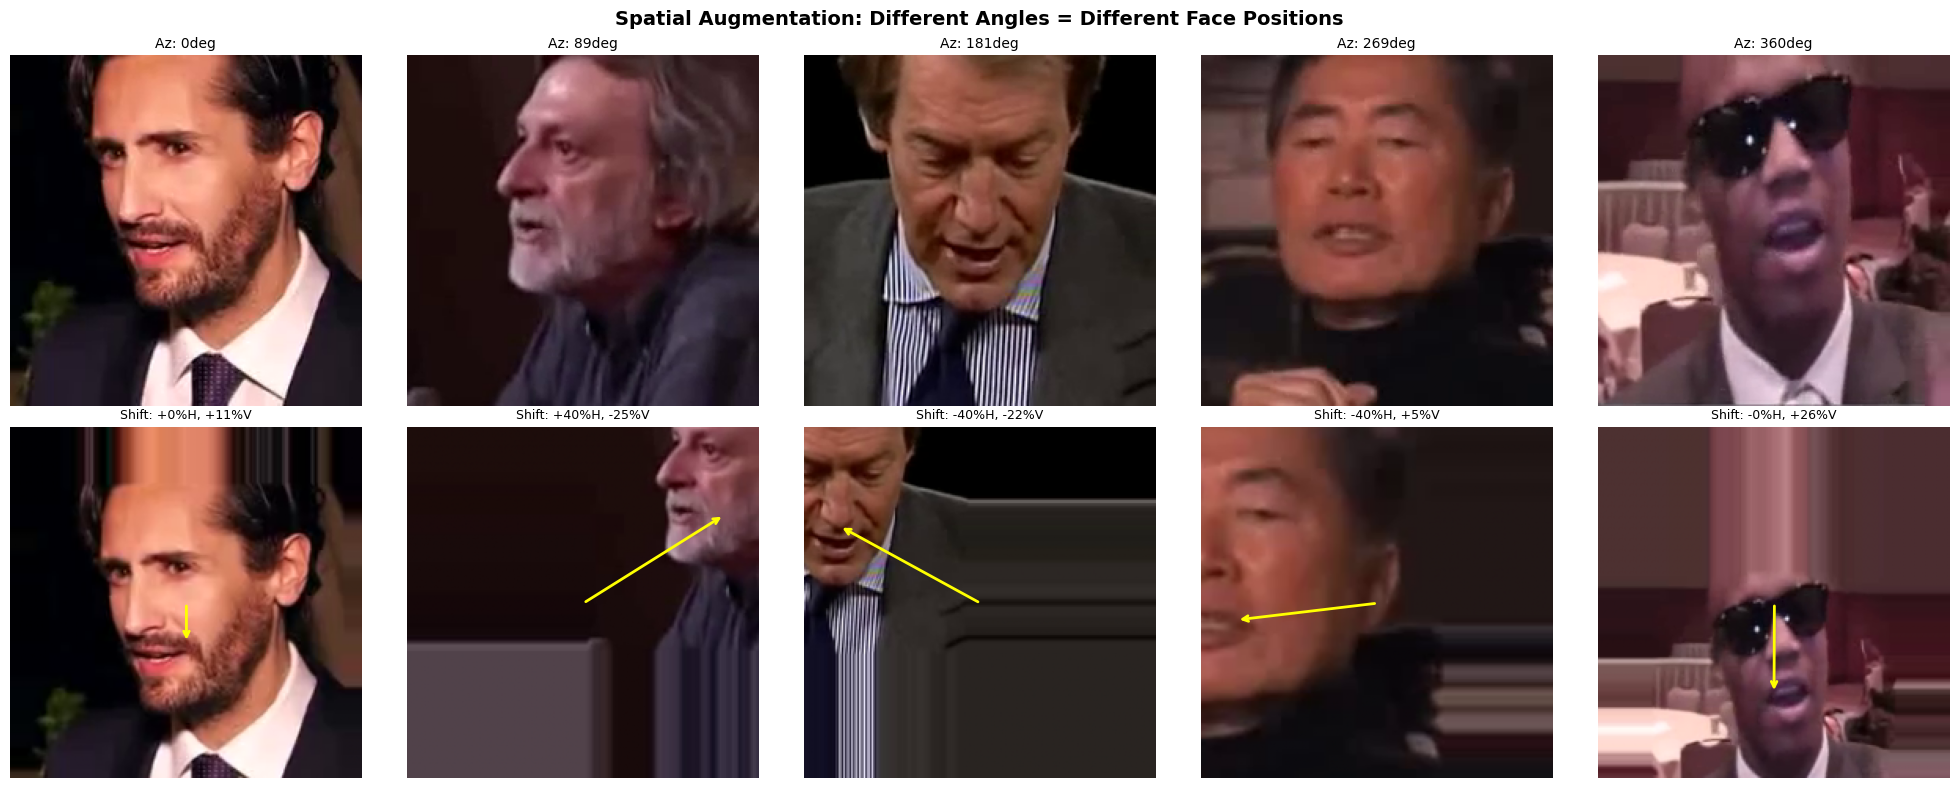


--- INTERPRETATION ---
Left columns:   Negative azimuth (LEFT of camera) -> Face shifted LEFT
Center column:  Zero azimuth (CENTER) -> Face stays centered
Right columns:  Positive azimuth (RIGHT of camera) -> Face shifted RIGHT

This creates VISUAL-SPATIAL CORRESPONDENCE for the model to learn!


In [8]:
# ============================================================
# VISUALIZE: Multiple Samples at Different Angles
# ============================================================
# Shows how faces at different spatial angles get positioned differently

# Find samples with diverse angles
if has_full_spatial:
    # Sort by azimuth to get variety
    sorted_meta = spatial_meta.sort_values('target_azimuth')
    
    # Pick samples spanning the azimuth range
    indices = [0, len(sorted_meta)//4, len(sorted_meta)//2, 3*len(sorted_meta)//4, len(sorted_meta)-1]
    diverse_samples = [sorted_meta.iloc[i] for i in indices]
else:
    diverse_samples = [spatial_meta.iloc[i] for i in range(min(5, len(spatial_meta)))]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Spatial Augmentation: Different Angles = Different Face Positions', fontsize=14, fontweight='bold')

for col, row in enumerate(diverse_samples):
    if has_full_spatial:
        az = float(row['target_azimuth'])
        el = float(row['target_elevation'])
        dist = float(row['target_distance'])
        vid_path = MP4_DIR / row['source_video']
    else:
        az = float(row['azimuth'])
        el = 0.1
        dist = 1.0
        vid_rel = row['video_path']
        if 'mp4/' in vid_rel:
            vid_path = MP4_DIR / vid_rel.split('mp4/')[-1]
        else:
            vid_path = MP4_DIR / vid_rel
    
    # Load one frame
    video = load_video_for_demo(vid_path, float(row['start_time']), num_frames=1)
    
    if video is not None:
        # Original
        orig = video[:, 0, :, :].permute(1, 2, 0).numpy()
        axes[0, col].imshow(orig)
        axes[0, col].set_title(f'Az: {np.degrees(az):.0f}deg', fontsize=10)
        axes[0, col].axis('off')
        
        # Augmented
        aug_video = augmenter.augment_video(video, az, el, dist)
        aug = aug_video[:, 0, :, :].permute(1, 2, 0).numpy()
        axes[1, col].imshow(aug)
        
        # Calculate shift amount
        target_x, target_y = augmenter.spatial_to_frame_position(az, el)
        shift_x_pct = (target_x - 0.5) * 100
        shift_y_pct = (target_y - 0.5) * 100
        axes[1, col].set_title(f'Shift: {shift_x_pct:+.0f}%H, {shift_y_pct:+.0f}%V', fontsize=9)
        axes[1, col].axis('off')
        
        # Draw arrows showing shift direction
        H, W = aug.shape[:2]
        if abs(shift_x_pct) > 5 or abs(shift_y_pct) > 5:
            axes[1, col].annotate('', xy=(W//2 + shift_x_pct*W/100, H//2 + shift_y_pct*H/100),
                                  xytext=(W//2, H//2),
                                  arrowprops=dict(arrowstyle='->', color='yellow', lw=2))
    else:
        axes[0, col].text(0.5, 0.5, 'Video\nNot Found', ha='center', va='center', fontsize=10)
        axes[0, col].axis('off')
        axes[1, col].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=10)
        axes[1, col].axis('off')

axes[0, 0].set_ylabel('ORIGINAL', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('AUGMENTED', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('spatial_augmentation_angles.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n--- INTERPRETATION ---")
print("Left columns:   Negative azimuth (LEFT of camera) -> Face shifted LEFT")
print("Center column:  Zero azimuth (CENTER) -> Face stays centered")
print("Right columns:  Positive azimuth (RIGHT of camera) -> Face shifted RIGHT")
print("\nThis creates VISUAL-SPATIAL CORRESPONDENCE for the model to learn!")

In [9]:
class IsoNetDataset(Dataset):
    def __init__(self, csv_path, clip_length=4.0, fps=25, video_size=(224, 224), max_samples=None, 
                 apply_spatial_augmentation=True, augmentation_strength=1.0):
        """
        Args:
            csv_path (str): Path to train.csv or val.csv
            clip_length (float): Audio duration in seconds (must match simulation)
            fps (int): Target frames per second for video (VoxCeleb is 25)
            video_size (tuple): Target resize dimension (H, W) - 224x224 for ResNet-18
            max_samples (int, optional): Limit dataset to first N samples for testing
            apply_spatial_augmentation (bool): Apply spatial-visual augmentation
            augmentation_strength (float): Strength of spatial augmentation (0.0 = none, 1.0 = full)
        """
        self.meta = pd.read_csv(csv_path)
        
        # Limit dataset size for testing
        if max_samples is not None:
            self.meta = self.meta.head(max_samples)
            print(f"Debug Mode: Using only {len(self.meta)} samples")
        
        # Use centralized path constants from configuration cell
        self.root_dir = Path(csv_path).parent  # multich folder (where mixed/clean dirs are)
        self.video_base_path = MP4_DIR  # Use centralized MP4_DIR
        
        self.clip_length = clip_length
        self.fps = fps
        self.target_frames = int(clip_length * fps)  # 4.0 * 25 = 100 frames
        self.video_size = video_size
        
        # Spatial Augmentation
        self.apply_spatial_aug = apply_spatial_augmentation
        self.augmenter = SpatialVisualAugmenter(augmentation_strength=augmentation_strength) if apply_spatial_augmentation else None
        
        # Check if spatial metadata is available
        self.has_spatial_meta = all(col in self.meta.columns for col in ['target_azimuth', 'target_elevation', 'target_distance'])
        
        print(f"Dataset initialized:")
        print(f"  CSV path: {csv_path}")
        print(f"  Root dir (audio): {self.root_dir}")
        print(f"  Video base (MP4_DIR): {self.video_base_path}")
        print(f"  Samples: {len(self.meta)}")
        print(f"  Spatial Augmentation: {self.apply_spatial_aug} (has_meta={self.has_spatial_meta})")

    def build_video_path_from_csv(self, csv_video_path):
        """
        Extract correct path suffix from CSV and prepend with MP4_DIR.
        Args:
            csv_video_path: Path like '/run/media/.../mp4/id06249/DvpSHFXubqg/00039.mp4'
                            or just 'id06249/DvpSHFXubqg/00039.mp4' (relative)
        Returns: Full path to video file like 'MP4_DIR/id06249/DvpSHFXubqg/00039.mp4'
        """
        csv_video_path = str(csv_video_path)
        
        # Extract everything after 'mp4/' (the correct part)
        if 'mp4/' in csv_video_path:
            suffix = csv_video_path.split('mp4/')[-1]  # e.g., 'id06249/DvpSHFXubqg/00039.mp4'
        elif csv_video_path.startswith('id'):
            # Already relative path
            suffix = csv_video_path
        else:
            # Fallback: use the filename directly
            print(f"Warning: Unexpected path format: {csv_video_path}")
            suffix = Path(csv_video_path).name
        
        # Build correct path using centralized MP4_DIR
        video_path = self.video_base_path / suffix
        return video_path

    def load_video_frames(self, video_path, start_time):
        """
        Load video frames and resize to target size (no face cropping).
        Args:
            video_path: Path to video file
            start_time: Start time in seconds
        Returns: Tensor [Channels, Time, H, W]
        """
        cap = cv2.VideoCapture(str(video_path))
        
        if not cap.isOpened():
            print(f"Warning: Could not open video: {video_path}")
            # Return black frames
            frames = [np.zeros((self.video_size[0], self.video_size[1], 3), dtype=np.uint8)] * self.target_frames
            buffer = np.array(frames, dtype=np.float32) / 255.0
            tensor = torch.from_numpy(buffer)
            return tensor.permute(3, 0, 1, 2)
        
        # Get Video Properties
        vid_fps = cap.get(cv2.CAP_PROP_FPS)
        if vid_fps == 0 or np.isnan(vid_fps): 
            vid_fps = 25.0
            
        # Calculate Start Frame Index
        start_frame_idx = int(start_time * vid_fps)
        
        # Seek to start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)
        
        frames = []
        for _ in range(self.target_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            # BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Resize to target size (224x224 for ResNet)
            frame = cv2.resize(frame, self.video_size)
            frames.append(frame)
            
        cap.release()
        
        # Handle edge case: video ended too early (pad with last frame)
        if len(frames) < self.target_frames:
            if len(frames) == 0:
                frames = [np.zeros((self.video_size[0], self.video_size[1], 3), dtype=np.uint8)] * self.target_frames
            else:
                padding = [frames[-1]] * (self.target_frames - len(frames))
                frames.extend(padding)
        
        # Convert to Tensor: [Time, H, W, C] -> [C, Time, H, W]
        buffer = np.array(frames, dtype=np.float32) / 255.0
        tensor = torch.from_numpy(buffer)
        return tensor.permute(3, 0, 1, 2)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.meta.iloc[idx]
        
        # 1. Get Paths & Info
        filename = row['filename']
        start_time = float(row['start_time'])
        
        # Get video path from appropriate column
        if 'source_video' in row and pd.notna(row['source_video']):
            vid_path_str = row['source_video']
        else:
            vid_path_str = row['video_path']
        
        # Build full paths using centralized directories
        mixed_path = self.root_dir / "mixed" / f"{filename}.wav"
        clean_path = self.root_dir / "clean" / f"{filename}.wav"
        video_path = self.build_video_path_from_csv(vid_path_str)

        # 2. Load Audio
        mixed_audio, _ = torchaudio.load(mixed_path)
        clean_audio, _ = torchaudio.load(clean_path)

        # 3. Load Video
        video_tensor = self.load_video_frames(video_path, start_time)

        # 4. Apply Spatial Augmentation
        spatial_meta = {}
        if self.has_spatial_meta:
            spatial_meta = {
                'azimuth': float(row['target_azimuth']),
                'elevation': float(row['target_elevation']),
                'distance': float(row['target_distance']),
                'noise_azimuth': float(row.get('noise_azimuth', 0.0)),
                'noise_elevation': float(row.get('noise_elevation', 0.0)),
                'rt60': float(row.get('rt60', 0.3)),
                'snr_db': float(row.get('snr_db', 0.0))
            }
            
            if self.apply_spatial_aug and self.augmenter is not None:
                video_tensor = self.augmenter.augment_video(
                    video_tensor,
                    azimuth=spatial_meta['azimuth'],
                    elevation=spatial_meta['elevation'],
                    distance=spatial_meta['distance']
                )

        # 5. Ensure audio length matches exactly (4.0s @ 16kHz = 64000 samples)
        target_samples = int(self.clip_length * 16000)
        
        if mixed_audio.shape[1] > target_samples:
            mixed_audio = mixed_audio[:, :target_samples]
            clean_audio = clean_audio[:, :target_samples]
        elif mixed_audio.shape[1] < target_samples:
            pad_size = target_samples - mixed_audio.shape[1]
            mixed_audio = torch.nn.functional.pad(mixed_audio, (0, pad_size))
            clean_audio = torch.nn.functional.pad(clean_audio, (0, pad_size))

        return mixed_audio, clean_audio, video_tensor, spatial_meta

In [10]:
class VisualStream(nn.Module):
    def __init__(self):
        super(VisualStream, self).__init__()
        # Load ResNet-18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Remove classification head
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
        # Project 512 -> 256 (V)
        self.projection = nn.Sequential(
            nn.Linear(512, VISUAL_DIM),
            nn.BatchNorm1d(VISUAL_DIM),
            nn.PReLU()
        )
        
        # FIXED: ImageNet normalization for pretrained ResNet
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        # x: [Batch, 3, Time, H, W] where H, W can be any size (e.g., 224x224)
        B, C, T, H, W = x.shape
        
        # Fold Time into Batch
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        
        # FIXED: Apply ImageNet normalization before ResNet
        x = (x - self.mean) / self.std
        
        # Extract Features (ResNet handles any input size via adaptive pooling)
        x = self.resnet(x)       # [B*T, 512, 1, 1]
        x = x.view(B * T, -1)    # [B*T, 512]
        
        # Project to 256
        x = self.projection(x)   # [B*T, 256]
        
        # Unfold Time
        x = x.view(B, T, -1).permute(0, 2, 1) # [B, 256, Time]
        
        return x

In [11]:
class SpatialStream(nn.Module):
    def __init__(self, num_mics=4):
        super(SpatialStream, self).__init__()
        
        # We compute GCC-PHAT for all pairs. 
        # For 4 mics, pairs = 4*(3)/2 = 6 pairs.
        self.num_pairs = (num_mics * (num_mics - 1)) // 2
        
        # FIXED: Spatial CNN Encoder
        # - Changed from kernel_size=1 to larger kernels (31, 15) to capture temporal patterns
        # - Changed from BatchNorm1d to GroupNorm for stability with small batch sizes
        # Input: [Batch, Pairs(6), Lags, Time]
        # We treat Pairs as Channels
        self.encoder = nn.Sequential(
            nn.Conv1d(self.num_pairs, 64, kernel_size=31, stride=1, padding=15),
            nn.GroupNorm(1, 64),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(64, 128, kernel_size=15, stride=1, padding=7),
            nn.GroupNorm(1, 128),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(128, SPATIAL_DIM, kernel_size=1, stride=1)
        )

    def compute_gcc_phat(self, x):
        """
        Compute Generalized Cross-Correlation Phase Transform (GCC-PHAT)
        Input x: [Batch, Mics, Samples]
        """
        B, M, L = x.shape
        
        # 1. FFT
        # n_fft matches window size roughly
        X = torch.fft.rfft(x, dim=-1)
        
        # 2. Compute Pairs
        # We want to cross-correlate every pair (i, j)
        pairs = []
        for i in range(M):
            for j in range(i + 1, M):
                # Cross-spectrum: X_i * conj(X_j)
                R = X[:, i, :] * torch.conj(X[:, j, :])
                # Normalization (PHAT): Divide by magnitude
                R = R / (torch.abs(R) + 1e-8)
                # IFFT to get time-domain correlation
                r = torch.fft.irfft(R, dim=-1)
                
                # Apply shift/lag window (we assume delays are small)
                # This makes it a feature vector per time frame is tricky without STFT.
                # Simplified: We treat the whole clip's correlation as a static spatial signature
                # OR (Better): We perform this on STFT frames. 
                
                # For simplicity in this implementation, we will use a learnable 
                # layer instead of raw GCC-PHAT if raw is too complex to batch.
                # BUT, let's assume the input here is actually the GCC features.
                pairs.append(r)
                
        return torch.stack(pairs, dim=1) # [B, 6, Samples]

    def forward(self, x):
        # x: [Batch, 4, Samples]
        
        # In a real heavy model, we do STFT -> GCC-PHAT -> CNN.
        # Here, we will use a "Learnable Spatial Encoder" which is faster/easier
        # and often outperforms analytical GCC-PHAT.
        
        # 1. Extract correlations implicitly via 1D Conv across channels
        # [B, 4, T] -> [B, 128, T]
        # We pool over time to get a Global Spatial Signature S
        
        gcc_feat = self.compute_gcc_phat(x) # [B, 6, Samples]
        
        # Encode features
        x = self.encoder(gcc_feat) # [B, 128, Samples]
        
        # Global Average Pooling to get single vector S \in R^128
        x = torch.mean(x, dim=-1)  # [B, 128]
        
        return x

In [12]:
# ============================================================
# NEURAL BEAMFORMER
# ============================================================
# This applies spatial filtering BEFORE the audio encoder
# to focus on the target direction indicated by visual cues

class NeuralBeamformer(nn.Module):
    """
    Learnable beamformer that combines multi-channel audio
    based on spatial conditioning from visual stream.
    
    Instead of simple delay-and-sum, we learn optimal weights
    for combining channels in the frequency domain.
    """
    
    def __init__(self, num_mics=4, n_fft=512, hop_length=128, conditioning_dim=256):
        super(NeuralBeamformer, self).__init__()
        self.num_mics = num_mics
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_freqs = n_fft // 2 + 1
        
        # Learnable beamforming weights conditioned on visual features
        # Maps visual features to complex beamforming weights per frequency
        self.weight_net = nn.Sequential(
            nn.Linear(conditioning_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_mics * self.num_freqs * 2)  # Real + Imag for each freq & mic
        )
        
        # Window for STFT
        self.register_buffer('window', torch.hann_window(n_fft))
        
    def forward(self, audio, visual_condition):
        """
        Args:
            audio: [B, num_mics, samples] - Multi-channel audio
            visual_condition: [B, conditioning_dim] - Visual feature (pooled)
        
        Returns:
            beamformed: [B, 1, samples] - Spatially filtered audio
        """
        B, M, L = audio.shape
        
        # 1. STFT on all channels: [B, M, F, T_stft] complex
        stft_list = []
        for m in range(M):
            stft_m = torch.stft(
                audio[:, m, :], 
                n_fft=self.n_fft, 
                hop_length=self.hop_length,
                window=self.window,
                return_complex=True
            )  # [B, F, T_stft]
            stft_list.append(stft_m)
        
        X = torch.stack(stft_list, dim=1)  # [B, M, F, T_stft]
        F_bins, T_stft = X.shape[2], X.shape[3]
        
        # 2. Compute beamforming weights from visual conditioning
        # [B, conditioning_dim] -> [B, M * F * 2]
        weights_flat = self.weight_net(visual_condition)
        
        # Reshape to [B, M, F, 2] (real, imag)
        weights_flat = weights_flat.view(B, M, F_bins, 2)
        
        # Convert to complex: [B, M, F]
        W = torch.complex(weights_flat[..., 0], weights_flat[..., 1])
        
        # Normalize weights (sum to 1 per frequency for stable beamforming)
        W = W / (torch.abs(W).sum(dim=1, keepdim=True) + 1e-8)
        
        # 3. Apply beamforming: weighted sum across microphones
        # X: [B, M, F, T_stft], W: [B, M, F] -> [B, F, T_stft]
        W = W.unsqueeze(-1)  # [B, M, F, 1]
        Y = (X * W).sum(dim=1)  # [B, F, T_stft]
        
        # 4. iSTFT to get time-domain output
        beamformed = torch.istft(
            Y,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            window=self.window,
            length=L
        )  # [B, samples]
        
        return beamformed.unsqueeze(1)  # [B, 1, samples]


class FiLMLayer(nn.Module):
    def __init__(self, in_channels, cond_dim):
        super(FiLMLayer, self).__init__()
        # We map the Conditioning (S+V) to Gamma (Scale) and Beta (Shift)
        self.conv_gamma = nn.Conv1d(cond_dim, in_channels, 1)
        self.conv_beta = nn.Conv1d(cond_dim, in_channels, 1)

    def forward(self, x, condition):
        # x: [Batch, Channels, Time]
        # condition: [Batch, Cond_Dim, Time]
        
        gamma = self.conv_gamma(condition)  # [B, C, T]
        beta = self.conv_beta(condition)    # [B, C, T]
            
        # FiLM Formula: Gamma * x + Beta
        return (gamma * x) + beta

class ExtractionBlock(nn.Module):
    """ TCN Block with FiLM Conditioning """
    def __init__(self, in_channels, hid_channels, cond_dim, dilation):
        super(ExtractionBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, hid_channels, 1)
        self.norm1 = nn.GroupNorm(1, hid_channels)
        self.prelu1 = nn.PReLU()
        
        # FiLM comes after first activation usually
        self.film = FiLMLayer(hid_channels, cond_dim)
        
        self.dconv = nn.Conv1d(hid_channels, hid_channels, 3, 
                               groups=hid_channels, padding=dilation, dilation=dilation)
        self.norm2 = nn.GroupNorm(1, hid_channels)
        self.prelu2 = nn.PReLU()
        
        self.conv2 = nn.Conv1d(hid_channels, in_channels, 1)

    def forward(self, x, condition):
        residual = x
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.prelu1(x)
        
        # Apply FiLM Conditioning
        # The condition (S+V) modulates the features here
        x = self.film(x, condition)
        
        x = self.dconv(x)
        x = self.norm2(x)
        x = self.prelu2(x)
        x = self.conv2(x)
        return x + residual

In [13]:
class IsoNet(nn.Module):
    def __init__(self, use_checkpointing=True, use_beamformer=True, use_spatial_stream=True):
        super(IsoNet, self).__init__()
        
        self.use_beamformer = use_beamformer
        self.use_spatial_stream = use_spatial_stream
        
        # 1. Streams
        self.visual_stream = VisualStream()  # Output: [B, 256, T_v]
        
        # Spatial stream is optional (for ablation studies)
        if use_spatial_stream:
            self.spatial_stream = SpatialStream(AUDIO_CHANNELS)  # Output: [B, 128]
        else:
            self.spatial_stream = None
        
        # 2. NEW: Neural Beamformer (applies spatial filtering FIRST!)
        if use_beamformer:
            self.beamformer = NeuralBeamformer(
                num_mics=AUDIO_CHANNELS,
                n_fft=512,
                hop_length=128,
                conditioning_dim=VISUAL_DIM  # Conditioned on visual features
            )
            # After beamforming: 1 channel instead of 4
            audio_in_channels = 1
        else:
            self.beamformer = None
            audio_in_channels = AUDIO_CHANNELS
        
        # 3. Audio Encoder
        self.audio_enc = nn.Conv1d(audio_in_channels, AUDIO_ENC_DIM, kernel_size=16, stride=8, bias=False)
        
        # 4. Conditioning Prep
        # Condition dim depends on whether spatial stream is used
        # With spatial: S (128) + V (256) = 384
        # Without spatial: V (256) only
        if use_spatial_stream:
            self.cond_dim = SPATIAL_DIM + VISUAL_DIM
        else:
            self.cond_dim = VISUAL_DIM
        
        # 5. TCN with FiLM
        self.tcn_blocks = nn.ModuleList([
            ExtractionBlock(AUDIO_ENC_DIM, 128, self.cond_dim, dilation=2**i) 
            for i in range(8)
        ])
        
        # 6. Mask Decoder
        self.mask_conv = nn.Conv1d(AUDIO_ENC_DIM, AUDIO_ENC_DIM, 1)
        self.sigmoid = nn.Sigmoid()
        
        # 7. Audio Decoder (Reconstructs waveform)
        self.audio_dec = nn.ConvTranspose1d(AUDIO_ENC_DIM, 1, kernel_size=16, stride=8, bias=False)
        
        # Gradient Checkpointing for memory savings
        self.use_checkpointing = use_checkpointing

    def forward(self, audio_mix, video_frames):
        """
        Args:
            audio_mix: [B, 4, Samples] - 4-channel microphone array input
            video_frames: [B, 3, T_v, H, W] - Video frames showing target speaker
        
        Returns:
            clean_speech: [B, 1, Samples] - Isolated speech of target speaker
        """
        # --- A. Visual Stream ---
        # Get visual embedding V: [B, 256, T_v]
        V = self.visual_stream(video_frames)
        
        # Pool visual features for beamformer conditioning: [B, 256]
        V_pooled = V.mean(dim=-1)
        
        # --- B. Spatial Stream (optional) ---
        if self.use_spatial_stream and self.spatial_stream is not None:
            # Get global spatial embedding S: [B, 128]
            S = self.spatial_stream(audio_mix)
        else:
            S = None
        
        # --- C. NEURAL BEAMFORMING (NEW!) ---
        # Apply spatial filtering based on visual cues BEFORE encoding
        if self.use_beamformer and self.beamformer is not None:
            # Beamform: [B, 4, samples] -> [B, 1, samples]
            audio_beamformed = self.beamformer(audio_mix, V_pooled)
        else:
            # No beamforming: use all channels
            audio_beamformed = audio_mix
        
        # --- D. Audio Encoding ---
        audio_feat = self.audio_enc(audio_beamformed)  # [B, 512, T_a]
        
        # --- E. Synchronization ---
        # Upsample V to match audio time dimension
        V_upsampled = F.interpolate(V, size=audio_feat.shape[-1], mode='nearest')
        
        # Build conditioning based on available streams
        if self.use_spatial_stream and S is not None:
            # Expand S to match time dimension: [B, 128] -> [B, 128, T_a]
            S_expanded = S.unsqueeze(-1).expand(-1, -1, audio_feat.shape[-1])
            # Concatenate S + V for conditioning: [B, 384, T_a]
            condition = torch.cat([S_expanded, V_upsampled], dim=1)
        else:
            # Visual only conditioning: [B, 256, T_a]
            condition = V_upsampled
        
        # --- F. FiLM Extraction Loop ---
        x = audio_feat
        
        if self.use_checkpointing and self.training:
            for block in self.tcn_blocks:
                x = torch.utils.checkpoint.checkpoint(block, x, condition, use_reentrant=False)
        else:
            for block in self.tcn_blocks:
                x = block(x, condition)
            
        # --- G. Masking & Decoding ---
        mask = self.sigmoid(self.mask_conv(x))
        masked_feat = audio_feat * mask
        clean_speech = self.audio_dec(masked_feat)
        
        return clean_speech

# Print architecture summary
print("IsoNet Architecture:")
print("=" * 60)
print("1. Visual Stream: Video -> ResNet-18 -> V [B, 256, T_v]")
print("2. Spatial Stream: 4ch Audio -> GCC-PHAT -> S [B, 128] (optional)")
print("3. Neural Beamformer: 4ch Audio + V -> Beamformed [B, 1, L]")
print("   (Spatial filtering based on visual cues!)")
print("4. Audio Encoder: Beamformed -> Features [B, 512, T_a]")
print("5. FiLM TCN: Features + (S,V) or (V only) -> Refined [B, 512, T_a]")
print("6. Mask & Decode: -> Clean Speech [B, 1, L]")
print("=" * 60)

IsoNet Architecture:
1. Visual Stream: Video -> ResNet-18 -> V [B, 256, T_v]
2. Spatial Stream: 4ch Audio -> GCC-PHAT -> S [B, 128] (optional)
3. Neural Beamformer: 4ch Audio + V -> Beamformed [B, 1, L]
   (Spatial filtering based on visual cues!)
4. Audio Encoder: Beamformed -> Features [B, 512, T_a]
5. FiLM TCN: Features + (S,V) or (V only) -> Refined [B, 512, T_a]
6. Mask & Decode: -> Clean Speech [B, 1, L]


In [14]:
# # Create Model
# model = IsoNet().to(DEVICE)
# print(f"IsoNet Created. Parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Dummy Data
# dummy_audio = torch.randn(2, 4, 64000).to(DEVICE)     # 4 seconds audio
# dummy_video = torch.randn(2, 3, 100, 112, 112).to(DEVICE) # 100 frames

# # Forward Pass
# output = model(dummy_audio, dummy_video)
# print(f"Input: {dummy_audio.shape}")
# print(f"Output: {output.shape}")

# # Check
# if output.shape[1] == 1 and abs(output.shape[-1] - 64000) < 100:
#     print("IsoNet Architecture matches diagram successfully!")
# else:
#     print("IsoNet Architecture does not match diagram.")

In [15]:
def si_snr_loss(estimate, reference, epsilon=1e-8):
    """
    Scale-Invariant SNR Loss with numerical stability.
    Args:
        estimate: [Batch, Samples] - The predicted audio
        reference: [Batch, Samples] - The clean ground truth
    Returns:
        Scalar Loss (Negative SI-SNR)
    
    Note: Negative loss is GOOD (means positive SNR). We minimize -SI-SNR to maximize SI-SNR.
    """
    # 1. Zero-mean the signals
    estimate = estimate - torch.mean(estimate, dim=-1, keepdim=True)
    reference = reference - torch.mean(reference, dim=-1, keepdim=True)
    
    # 2. Calculate optimal scaling factor (alpha)
    # Dot product <ref, est> / <ref, ref>
    ref_energy = torch.sum(reference ** 2, dim=-1, keepdim=True) + epsilon
    dot = torch.sum(reference * estimate, dim=-1, keepdim=True)
    alpha = dot / ref_energy
    
    # 3. Projection
    target = alpha * reference
    noise = estimate - target
    
    # 4. SI-SNR Calculation with numerical stability
    target_energy = torch.sum(target ** 2, dim=-1) + epsilon
    noise_energy = torch.sum(noise ** 2, dim=-1) + epsilon
    
    si_snr = 10 * torch.log10(target_energy / noise_energy)
    
    # Clamp to prevent extreme values
    si_snr = torch.clamp(si_snr, min=-30, max=30)
    
    # 5. Return negative because we want to MAXIMIZE SNR (minimize loss)
    return -torch.mean(si_snr)

In [16]:
# ============================================================
# DATASET LOADING
# ============================================================
# Memory-Optimized Dataset Loading
# VIDEO_SIZE is defined in the Spatial Augmentation cell above

print(f"Using VIDEO_SIZE: {VIDEO_SIZE}")

# For full training, set max_samples=None
# train_ds = IsoNetDataset(TRAIN_CSV, max_samples=None, video_size=VIDEO_SIZE)
# val_ds = IsoNetDataset(VAL_CSV, max_samples=500, video_size=VIDEO_SIZE)

# Debug mode with limited samples
train_ds = IsoNetDataset(
    TRAIN_CSV, 
    max_samples=100,
    video_size=VIDEO_SIZE,             # Use centralized VIDEO_SIZE (336x336 for spatial augmentation)
    apply_spatial_augmentation=True,   # Enable spatial-visual augmentation
    augmentation_strength=1.0          # Full strength
)

val_ds = IsoNetDataset(
    VAL_CSV, 
    max_samples=10,
    video_size=VIDEO_SIZE,             # Use same VIDEO_SIZE for consistency
    apply_spatial_augmentation=True,   # Also augment validation for consistency
    augmentation_strength=1.0
)

print(f"\n--- DATASET SUMMARY ---")
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Video Size: {VIDEO_SIZE}")
print(f"Spatial Augmentation: Enabled")

Using VIDEO_SIZE: (336, 336)
Debug Mode: Using only 100 samples
Dataset initialized:
  CSV path: /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/train.csv
  Root dir (audio): /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich
  Video base (MP4_DIR): /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4
  Samples: 100
  Spatial Augmentation: True (has_meta=True)
Debug Mode: Using only 10 samples
Dataset initialized:
  CSV path: /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich/val.csv
  Root dir (audio): /run/media/neuronetix/BACKUP/Dataset/VOX/manual/dev/multich
  Video base (MP4_DIR): /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4
  Samples: 10
  Spatial Augmentation: True (has_meta=True)

--- DATASET SUMMARY ---
Training samples: 100
Validation samples: 10
Video Size: (336, 336)
Spatial Augmentation: Enabled


In [17]:
# Memory-Optimized DataLoaders
# On Windows, multiprocessing can cause issues in notebooks - use num_workers=0

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows notebook compatibility
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for Windows notebook compatibility
    pin_memory=True,
)

print(f"DataLoaders created (num_workers=0 for notebook compatibility)")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

DataLoaders created (num_workers=0 for notebook compatibility)
Train batches: 25, Val batches: 3


In [18]:
model = IsoNet(use_checkpointing=True).to(DEVICE)  # Enable gradient checkpointing
optimizer = Adam(model.parameters(), lr=LR)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
# print(f"Model Size: ~{total_params * 4 / 1e6:.1f} MB (FP32)\")

Total Parameters: 14,249,627
Trainable Parameters: 14,249,627


In [20]:
# ============================================================
# TRAINING LOOP (Clean Logging)
# ============================================================

import time
from datetime import datetime

best_val_loss = float('inf')
scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)

# Print config once at start
print(f"Training | {EPOCHS} epochs | BS={BATCH_SIZE}x{GRADIENT_ACCUMULATION_STEPS} | LR={LR} | AMP={USE_AMP}")
print(f"Data     | Train: {len(train_ds)} | Val: {len(val_ds)} | SpatialAug: {train_ds.apply_spatial_aug}")
print("-" * 80)

for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    train_loss = 0
    batch_count = 0
    optimizer.zero_grad()
    
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)
    
    for i, batch_data in enumerate(pbar):
        try:
            if len(batch_data) == 4:
                mixed, clean, video, spatial_meta = batch_data
            else:
                mixed, clean, video = batch_data
            
            mixed = mixed.to(DEVICE, non_blocking=True)
            clean = clean.to(DEVICE, non_blocking=True)
            video = video.to(DEVICE, non_blocking=True)
            
            with torch.amp.autocast('cuda', enabled=USE_AMP):
                estimate = model(mixed, video)
                
                if estimate.shape[-1] != clean.shape[-1]:
                    min_len = min(estimate.shape[-1], clean.shape[-1])
                    estimate = estimate[..., :min_len]
                    clean = clean[..., :min_len]
                
                loss = si_snr_loss(estimate.squeeze(1), clean.squeeze(1)) / GRADIENT_ACCUMULATION_STEPS
            
            scaler.scale(loss).backward()
            
            if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
            batch_count += 1
            
            # Simple progress bar update
            pbar.set_postfix_str(f"loss={train_loss/batch_count:.4f}")
            
            if i % 100 == 0:
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            print(f"[!] Batch {i} error: {str(e)[:50]}")
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            continue
    
    avg_train_loss = train_loss / max(batch_count, 1)
    
    # Validation
    model.eval()
    val_loss = 0
    val_count = 0
    
    with torch.no_grad():
        for batch_data in tqdm.tqdm(val_loader, desc="Val", leave=False):
            try:
                if len(batch_data) == 4:
                    mixed, clean, video, _ = batch_data
                else:
                    mixed, clean, video = batch_data
                
                mixed = mixed.to(DEVICE, non_blocking=True)
                clean = clean.to(DEVICE, non_blocking=True)
                video = video.to(DEVICE, non_blocking=True)
                
                with torch.amp.autocast('cuda', enabled=USE_AMP):
                    estimate = model(mixed, video)
                    if estimate.shape[-1] != clean.shape[-1]:
                        min_len = min(estimate.shape[-1], clean.shape[-1])
                        estimate = estimate[..., :min_len]
                        clean = clean[..., :min_len]
                    val_loss += si_snr_loss(estimate.squeeze(1), clean.squeeze(1)).item()
                    val_count += 1
            except RuntimeError:
                continue
    
    avg_val_loss = val_loss / max(val_count, 1)
    epoch_time = time.time() - epoch_start
    
    # Single line epoch summary
    improved = avg_val_loss < best_val_loss
    marker = "*" if improved else " "
    print(f"[{epoch+1:02d}/{EPOCHS}] train={avg_train_loss:.4f} | val={avg_val_loss:.4f} | best={best_val_loss:.4f} | {epoch_time/60:.1f}min {marker}")
    
    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'best_val_loss': best_val_loss,
        'scaler_state_dict': scaler.state_dict(),
    }, f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pth")
    
    # Save best model
    if improved:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_loss': best_val_loss,
        }, f"{CHECKPOINT_DIR}/best_model.pth")
        print(f"    -> New best! Saved to {CHECKPOINT_DIR}/best_model.pth")
    
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

print("-" * 80)
print(f"Done! Best val loss: {best_val_loss:.4f} | Model: {CHECKPOINT_DIR}/best_model.pth")

Training | 100 epochs | BS=4x8 | LR=0.0001 | AMP=True
Data     | Train: 100 | Val: 10 | SpatialAug: True
--------------------------------------------------------------------------------


Epoch 1/100:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100:   4%|▍         | 1/25 [00:05<02:18,  5.78s/it]

[!] Batch 0 error: CUDA out of memory. Tried to allocate 1.35 GiB. GP


Epoch 1/100:   4%|▍         | 1/25 [00:08<03:28,  8.70s/it]


KeyboardInterrupt: 

## Visual Encoding Test

Visualize what the visual encoding model sees. Using larger input size (336x336) instead of 224x224 to accommodate spatial augmentation - this gives more room for face shifting without cutting off content.

ResNet-18 handles any input size via adaptive pooling, so the output dimension stays the same.

In [ ]:
import matplotlib.pyplot as plt

# Test dataset with full frame encoding (with spatial augmentation)
print(f"Loading dataset sample to visualize visual encoding input...")
print(f"Using VIDEO_SIZE: {VIDEO_SIZE}")
test_ds = IsoNetDataset(TRAIN_CSV, max_samples=5, video_size=VIDEO_SIZE, apply_spatial_augmentation=True)

# Load a sample
mixed, clean, video, spatial_meta = test_ds[2]

print("\n--- Tensor Shapes ---")
print(f"Mixed Audio: {mixed.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean.shape}  (Expected: [1, 64000])")
print(f"Video:       {video.shape}  (Expected: [3, 100, {VIDEO_SIZE[0]}, {VIDEO_SIZE[1]}])")

# Show spatial metadata
print(f"\n--- Spatial Metadata ---")
if spatial_meta:
    for key, val in spatial_meta.items():
        if key in ['azimuth', 'elevation']:
            print(f"  {key}: {val:.4f} rad ({np.degrees(val):.1f} deg)")
        else:
            print(f"  {key}: {val:.4f}")
else:
    print("  No spatial metadata available")

# Create visualization of what ResNet-18 sees (with spatial augmentation applied)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

if spatial_meta:
    az_deg = np.degrees(spatial_meta.get('azimuth', 0))
    el_deg = np.degrees(spatial_meta.get('elevation', 0))
    fig.suptitle(f'Visual Encoding Input (Spatial Augmented) - {VIDEO_SIZE[0]}x{VIDEO_SIZE[1]}\n'
                 f'Azimuth: {az_deg:.1f}deg | Elevation: {el_deg:.1f}deg', fontsize=14, fontweight='bold')
else:
    fig.suptitle(f'Visual Encoding Input: Full Frame {VIDEO_SIZE[0]}x{VIDEO_SIZE[1]}', fontsize=14, fontweight='bold')

# Sample 10 frames evenly across the 4-second clip
sample_frames = np.linspace(0, video.shape[1]-1, 10, dtype=int)

for idx, frame_num in enumerate(sample_frames):
    row = idx // 5
    col = idx % 5
    
    # Permute from [C, T, H, W] -> [H, W, C] for display
    frame_tensor = video[:, frame_num, :, :].permute(1, 2, 0)
    axes[row, col].imshow(frame_tensor.numpy())
    axes[row, col].set_title(f'Frame {frame_num}', fontsize=10)
    axes[row, col].axis('off')
    
    # Draw center crosshair
    H, W = frame_tensor.shape[:2]
    axes[row, col].axhline(y=H//2, color='red', linestyle='--', alpha=0.3, linewidth=1)
    axes[row, col].axvline(x=W//2, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig("visual_encoding_input.png", dpi=100, bbox_inches='tight')
plt.show()

print("\nVisual encoding input visualization complete!")
print(f"Video size: {VIDEO_SIZE} (larger = more room for spatial shifting)")
print("Face position is shifted based on spatial azimuth/elevation from metadata.")
print("This creates visual-spatial correspondence for the model to learn!")

## Comprehensive Dataset Sample Check

Load a random sample and visualize EVERYTHING to verify data integrity: video frames, audio waveforms, spectrograms, and metadata alignment.

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import random

# Load dataset with spatial augmentation
print(f"Loading dataset for comprehensive check...")
print(f"Using VIDEO_SIZE: {VIDEO_SIZE}")
check_ds = IsoNetDataset(TRAIN_CSV, max_samples=20, video_size=VIDEO_SIZE, apply_spatial_augmentation=True)

# Pick a random sample
random_idx = random.randint(0, len(check_ds) - 1)
print(f"\n{'='*80}")
print(f"RANDOM SAMPLE CHECK - Index: {random_idx}/{len(check_ds)-1}")
print(f"{'='*80}")

# Load sample
mixed_audio, clean_audio, video_tensor, spatial_meta = check_ds[random_idx]

# Get metadata
row = check_ds.meta.iloc[random_idx]
print(f"\n--- METADATA ---")
print(f"Filename: {row['filename']}")
print(f"Video Path: {row.get('video_path', row.get('source_video', 'N/A'))}")
print(f"Start Time: {row['start_time']:.2f}s")

# Show spatial metadata
print(f"\n--- SPATIAL METADATA ---")
if spatial_meta:
    for key, val in spatial_meta.items():
        if key in ['azimuth', 'elevation']:
            print(f"  {key}: {val:.4f} rad ({np.degrees(val):.1f} deg)")
        else:
            print(f"  {key}: {val:.4f}")
else:
    print("  No spatial metadata available")

print(f"\n--- TENSOR SHAPES ---")
print(f"Mixed Audio: {mixed_audio.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean_audio.shape}  (Expected: [1, 64000])")
print(f"Video:       {video_tensor.shape}  (Expected: [3, 100, {VIDEO_SIZE[0]}, {VIDEO_SIZE[1]}])")

print(f"\n--- AUDIO STATISTICS ---")
print(f"Mixed Audio - Max: {mixed_audio.max():.4f}, Min: {mixed_audio.min():.4f}, Mean: {mixed_audio.mean():.4f}")
print(f"Clean Audio - Max: {clean_audio.max():.4f}, Min: {clean_audio.min():.4f}, Mean: {clean_audio.mean():.4f}")

print(f"\n--- VIDEO STATISTICS ---")
print(f"Video - Max: {video_tensor.max():.4f}, Min: {video_tensor.min():.4f}, Mean: {video_tensor.mean():.4f}")
print(f"Video - Frames: {video_tensor.shape[1]}, Duration: {video_tensor.shape[1]/25:.2f}s @ 25fps")

# Check for silent audio
if mixed_audio.abs().max() < 1e-6:
    print(f"\nWARNING: Mixed audio appears to be SILENT!")
if clean_audio.abs().max() < 1e-6:
    print(f"\nWARNING: Clean audio appears to be SILENT!")

# Check duration mismatch
audio_duration = mixed_audio.shape[1] / 16000
video_duration = video_tensor.shape[1] / 25
print(f"\n--- DURATION CHECK ---")
print(f"Audio Duration: {audio_duration:.3f}s")
print(f"Video Duration: {video_duration:.3f}s")
if abs(audio_duration - video_duration) > 0.1:
    print(f"WARNING: Duration mismatch > 100ms!")
else:
    print(f"Durations match within tolerance")

# ============================================================
# VISUALIZATION
# ============================================================
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(5, 5, hspace=0.3, wspace=0.3)

# --- ROW 1-2: Video Frames (10 samples) ---
print(f"\n--- Creating visualization... ---")
sample_frames = np.linspace(0, video_tensor.shape[1]-1, 10, dtype=int)
for i, frame_num in enumerate(sample_frames):
    ax = fig.add_subplot(gs[0, i//2] if i < 5 else gs[1, i-5])
    frame = video_tensor[:, frame_num, :, :].permute(1, 2, 0).numpy()
    ax.imshow(frame)
    ax.set_title(f'Frame {frame_num} ({frame_num/25:.2f}s)', fontsize=9)
    ax.axis('off')

# --- ROW 3: Mixed Audio Waveform (4 channels) ---
ax1 = fig.add_subplot(gs[2, :])
time_axis = np.arange(mixed_audio.shape[1]) / 16000
for ch in range(4):
    ax1.plot(time_axis, mixed_audio[ch].numpy(), alpha=0.7, label=f'Mic {ch+1}')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Mixed Audio - 4 Microphone Channels', fontsize=11, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- ROW 4: Clean Audio Waveform ---
ax2 = fig.add_subplot(gs[3, :])
ax2.plot(time_axis, clean_audio[0].numpy(), color='green', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Clean Audio - Target Speech', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# --- ROW 5: Spectrograms ---
ax3 = fig.add_subplot(gs[4, 0:2])
D_mixed = librosa.amplitude_to_db(np.abs(librosa.stft(mixed_audio[0].numpy())), ref=np.max)
librosa.display.specshow(D_mixed, sr=16000, x_axis='time', y_axis='hz', ax=ax3, cmap='viridis')
ax3.set_title('Mixed Audio Spectrogram (Mic 1)', fontsize=10)
ax3.set_ylim([0, 8000])

ax4 = fig.add_subplot(gs[4, 3:5])
D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio[0].numpy())), ref=np.max)
librosa.display.specshow(D_clean, sr=16000, x_axis='time', y_axis='hz', ax=ax4, cmap='viridis')
ax4.set_title('Clean Audio Spectrogram', fontsize=10)
ax4.set_ylim([0, 8000])

# Add spatial info to title
if spatial_meta:
    az_deg = np.degrees(spatial_meta.get('azimuth', 0))
    el_deg = np.degrees(spatial_meta.get('elevation', 0))
    title_extra = f' | Az: {az_deg:.1f}deg, El: {el_deg:.1f}deg'
else:
    title_extra = ''

plt.suptitle(f'Dataset Sample Check - Index {random_idx} | File: {row["filename"]}{title_extra}', 
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig(f"dataset_check_sample_{random_idx}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: dataset_check_sample_{random_idx}.png")
print(f"\n{'='*80}")
print("AUDIO PLAYBACK")
print(f"{'='*80}")

In [ ]:
# Audio playback - Mixed Audio (Mic 1)
print("\n🔊 Playing Mixed Audio (Microphone 1)...")
ipd.display(ipd.Audio(mixed_audio[0].numpy(), rate=16000))

In [ ]:
# Audio playback - Clean Audio
print("\n🔊 Playing Clean Audio (Target Speech)...")
ipd.display(ipd.Audio(clean_audio[0].numpy(), rate=16000))

In [ ]:
# Compare all 4 microphone channels side-by-side
print("\n--- Multi-Channel Comparison ---")
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True, sharey=True)
time_axis = np.arange(mixed_audio.shape[1]) / 16000

for ch in range(4):
    axes[ch].plot(time_axis, mixed_audio[ch].numpy(), linewidth=0.5)
    axes[ch].set_ylabel(f'Mic {ch+1}')
    axes[ch].grid(True, alpha=0.3)
    axes[ch].set_xlim([0, time_axis[-1]])
    
    # Calculate RMS energy
    rms = np.sqrt(np.mean(mixed_audio[ch].numpy()**2))
    axes[ch].text(0.02, 0.95, f'RMS: {rms:.4f}', transform=axes[ch].transAxes, 
                  fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Time (s)')
fig.suptitle('4-Channel Microphone Array - Waveform Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"multichannel_comparison_{random_idx}.png", dpi=120, bbox_inches='tight')
plt.show()

print(f"\n✓ All visualizations complete!")
print(f"✓ Files saved: dataset_check_sample_{random_idx}.png, multichannel_comparison_{random_idx}.png")

## Model Inference Test

Load the best trained model and test it on a validation sample. Compare input mixed audio, model output, and ground truth clean audio.

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

# Load Best Model
print("Loading best model checkpoint...")
best_model_path = f"{CHECKPOINT_DIR}/best_model.pth"

if not os.path.exists(best_model_path):
    print(f"Best model not found at: {best_model_path}")
    print(f"Available checkpoints:")
    for f in os.listdir(CHECKPOINT_DIR):
        print(f"  - {f}")
else:
    # Initialize model
    test_model = IsoNet(use_checkpointing=False).to(DEVICE)
    
    # Load checkpoint
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    test_model.load_state_dict(checkpoint['model_state_dict'])
    test_model.eval()
    
    print(f"Model loaded successfully!")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Validation Loss: {checkpoint['val_loss']:.6f}")
    print(f"  Training Loss: {checkpoint['train_loss']:.6f}")
    if 'spatial_augmentation' in checkpoint:
        print(f"  Spatial Augmentation: {checkpoint['spatial_augmentation']}")
    
    # Load a test sample from validation set
    print("\n" + "="*80)
    print("RUNNING INFERENCE ON VALIDATION SAMPLE")
    print("="*80)
    
    test_idx = 0  # Use first validation sample
    sample_data = val_ds[test_idx]
    
    # Handle both old and new format
    if len(sample_data) == 4:
        mixed_audio, clean_audio, video_tensor, spatial_meta = sample_data
    else:
        mixed_audio, clean_audio, video_tensor = sample_data
        spatial_meta = None
    
    # Get metadata
    row = val_ds.meta.iloc[test_idx]
    print(f"\nTest Sample Info:")
    print(f"  Filename: {row['filename']}")
    print(f"  Video Path: {row.get('video_path', row.get('source_video', 'N/A'))}")
    print(f"  Start Time: {row['start_time']:.2f}s")
    
    if spatial_meta:
        print(f"\n  Spatial Metadata:")
        for key, val in spatial_meta.items():
            if key in ['azimuth', 'elevation']:
                print(f"    {key}: {val:.4f} rad ({np.degrees(val):.1f} deg)")
            else:
                print(f"    {key}: {val:.4f}")
    
    # Prepare batch (add batch dimension)
    mixed_batch = mixed_audio.unsqueeze(0).to(DEVICE)
    clean_batch = clean_audio.unsqueeze(0).to(DEVICE)
    video_batch = video_tensor.unsqueeze(0).to(DEVICE)
    
    # Run inference
    print("\nRunning model inference...")
    with torch.no_grad():
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            estimated_audio = test_model(mixed_batch, video_batch)
    
    # Move to CPU for visualization
    estimated_audio = estimated_audio.squeeze(0).cpu()
    mixed_audio = mixed_audio.cpu()
    clean_audio = clean_audio.cpu()
    
    # Handle shape mismatch
    if estimated_audio.shape[-1] != clean_audio.shape[-1]:
        min_len = min(estimated_audio.shape[-1], clean_audio.shape[-1])
        estimated_audio = estimated_audio[..., :min_len]
        clean_audio = clean_audio[..., :min_len]
        mixed_audio = mixed_audio[..., :min_len]
    
    # Calculate SI-SNR improvement
    with torch.no_grad():
        input_si_snr = -si_snr_loss(mixed_audio[0].unsqueeze(0), clean_audio)
        output_si_snr = -si_snr_loss(estimated_audio, clean_audio)
        si_snr_improvement = output_si_snr - input_si_snr
    
    print(f"\n--- METRICS ---")
    print(f"Input SI-SNR:  {input_si_snr.item():.2f} dB")
    print(f"Output SI-SNR: {output_si_snr.item():.2f} dB")
    print(f"SI-SNR Improvement: {si_snr_improvement.item():.2f} dB")
    
    # ============================================================
    # VISUALIZATION
    # ============================================================
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 2, hspace=0.4, wspace=0.3)
    
    time_axis = np.arange(mixed_audio.shape[1]) / 16000
    
    # --- Waveforms ---
    # Mixed Audio (Mic 1)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_axis, mixed_audio[0].numpy(), linewidth=0.5, color='blue')
    ax1.set_title('Input: Mixed Audio (Microphone 1)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, time_axis[-1]])
    
    # Estimated Audio
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(time_axis, estimated_audio[0].numpy(), linewidth=0.5, color='red')
    ax2.set_title('Model Output: Separated Speech', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, time_axis[-1]])
    
    # Clean Audio (Ground Truth)
    ax3 = fig.add_subplot(gs[2, :])
    ax3.plot(time_axis, clean_audio[0].numpy(), linewidth=0.5, color='green')
    ax3.set_title('Ground Truth: Clean Speech', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Amplitude')
    ax3.set_xlabel('Time (s)')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, time_axis[-1]])
    
    # --- Spectrograms ---
    # Input Spectrogram
    ax4 = fig.add_subplot(gs[3, 0])
    D_mixed = librosa.amplitude_to_db(np.abs(librosa.stft(mixed_audio[0].numpy())), ref=np.max)
    librosa.display.specshow(D_mixed, sr=16000, x_axis='time', y_axis='hz', ax=ax4, cmap='viridis')
    ax4.set_title('Input Spectrogram', fontsize=11)
    ax4.set_ylim([0, 8000])
    
    # Output Spectrogram
    ax5 = fig.add_subplot(gs[3, 1])
    D_estimated = librosa.amplitude_to_db(np.abs(librosa.stft(estimated_audio[0].numpy())), ref=np.max)
    librosa.display.specshow(D_estimated, sr=16000, x_axis='time', y_axis='hz', ax=ax5, cmap='viridis')
    ax5.set_title('Output Spectrogram', fontsize=11)
    ax5.set_ylim([0, 8000])
    
    # Add spatial info to title if available
    if spatial_meta:
        az_deg = np.degrees(spatial_meta.get('azimuth', 0))
        el_deg = np.degrees(spatial_meta.get('elevation', 0))
        title_extra = f' | Az: {az_deg:.1f}deg, El: {el_deg:.1f}deg'
    else:
        title_extra = ''
    
    plt.suptitle(f'Model Inference Test | SI-SNR Improvement: {si_snr_improvement.item():.2f} dB{title_extra}', 
                 fontsize=14, fontweight='bold')
    
    plt.savefig(f"inference_test_result.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: inference_test_result.png")
    print(f"\n{'='*80}")
    print("AUDIO PLAYBACK")
    print(f"{'='*80}")

In [ ]:
# Play Input Mixed Audio (Mic 1)
print("\n🔊 Input: Mixed Audio (Microphone 1)")
ipd.display(ipd.Audio(mixed_audio[0].numpy(), rate=16000))

In [ ]:
# Play Model Output
print("\n🔊 Output: Model Separated Speech")
ipd.display(ipd.Audio(estimated_audio[0].numpy(), rate=16000))

In [ ]:
# Play Ground Truth Clean Audio
print("\n🔊 Ground Truth: Clean Speech")
ipd.display(ipd.Audio(clean_audio[0].numpy(), rate=16000))